
# here the class shows if a transaction is fraud or not
# 1) 1--->fraud
# 2) 2--->valid

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


Using TensorFlow backend.


In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=2.0)

In [4]:
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["valid", "fraud"]

In [5]:
data=pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.shape

(284807, 31)

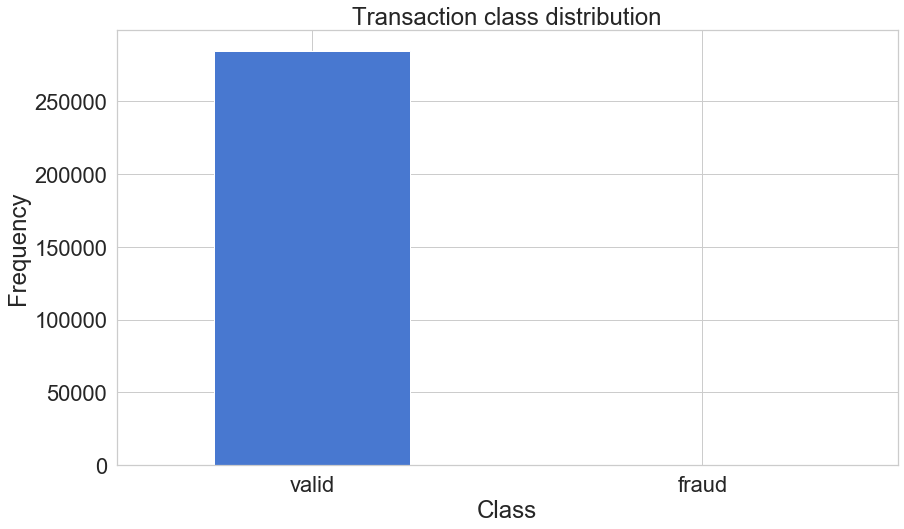

In [7]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");


In [8]:
fraud = data[data.Class == 1]
valid = data[data.Class == 0]

In [9]:
fraud.shape

(492, 31)

In [10]:
valid.shape

(284315, 31)

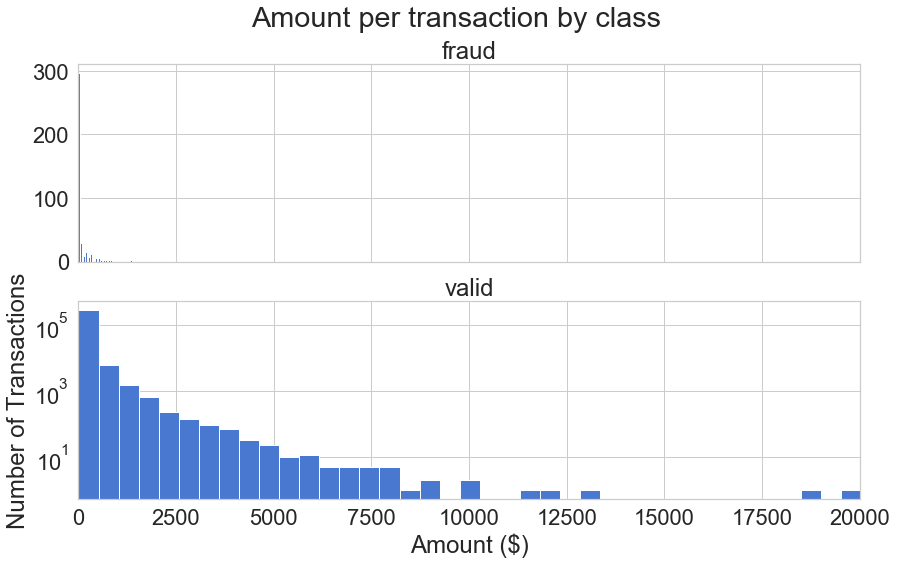

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('fraud')

ax2.hist(valid.Amount, bins = bins)
ax2.set_title('valid')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


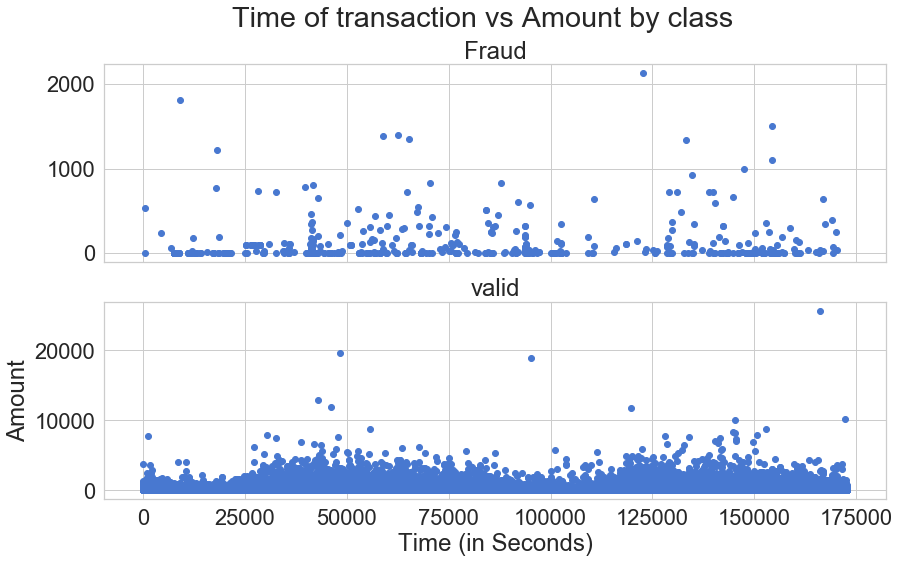

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')

ax2.scatter(valid.Time, valid.Amount)
ax2.set_title('valid')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler


In [14]:
data = data.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [15]:
X_train,X_test=train_test_split(data,test_size=0.2,random_state=1)
X_train=X_train[X_train.Class==0]
X_train=X_train.drop(['Class'],axis=1)

In [16]:
Y_test=X_test['Class']
X_test=X_test.drop(['Class'],axis=1)


In [17]:
X_train=X_train.values
X_test=X_test.values

In [18]:
X_train.shape

(227440, 29)

In [19]:
X_test.shape

(56962, 29)

In [20]:
input_dim = X_train.shape[1]
encoding_dim = 18

In [21]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [47]:
nb_epoch = 120
batch_size = 32

In [48]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


In [49]:

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1)
                    #callbacks=[checkpointer, tensorboard]).history

Train on 227440 samples, validate on 56962 samples
Epoch 1/120
227440/227440 [==============================] - 22s 97us/step - loss: 0.6778 - accuracy: 0.7241 - val_loss: 0.7050 - val_accuracy: 0.7223
Epoch 2/120
227440/227440 [==============================] - 30s 133us/step - loss: 0.6775 - accuracy: 0.7257 - val_loss: 0.7054 - val_accuracy: 0.7228
Epoch 3/120
227440/227440 [==============================] - 25s 110us/step - loss: 0.6770 - accuracy: 0.7266 - val_loss: 0.7037 - val_accuracy: 0.7253
Epoch 4/120
227440/227440 [==============================] - 28s 122us/step - loss: 0.6767 - accuracy: 0.7268 - val_loss: 0.7049 - val_accuracy: 0.7276
Epoch 5/120
227440/227440 [==============================] - 28s 125us/step - loss: 0.6768 - accuracy: 0.7281 - val_loss: 0.7032 - val_accuracy: 0.7291
Epoch 6/120
227440/227440 [==============================] - 26s 113us/step - loss: 0.6764 - accuracy: 0.7284 - val_loss: 0.7048 - val_accuracy: 0.7297
Epoch 7/120
227440/227440 [===========

227440/227440 [==============================] - 25s 110us/step - loss: 0.6717 - accuracy: 0.7323 - val_loss: 0.6995 - val_accuracy: 0.7326
Epoch 55/120
227440/227440 [==============================] - 22s 98us/step - loss: 0.6713 - accuracy: 0.7317 - val_loss: 0.6990 - val_accuracy: 0.7327
Epoch 56/120
227440/227440 [==============================] - 21s 92us/step - loss: 0.6714 - accuracy: 0.7327 - val_loss: 0.6968 - val_accuracy: 0.7302
Epoch 57/120
227440/227440 [==============================] - 21s 92us/step - loss: 0.6712 - accuracy: 0.7321 - val_loss: 0.7091 - val_accuracy: 0.7272
Epoch 58/120
227440/227440 [==============================] - 26s 116us/step - loss: 0.6715 - accuracy: 0.7319 - val_loss: 0.6974 - val_accuracy: 0.7324
Epoch 59/120
227440/227440 [==============================] - 27s 119us/step - loss: 0.6716 - accuracy: 0.7325 - val_loss: 0.6988 - val_accuracy: 0.7354
Epoch 60/120
227440/227440 [==============================] - 30s 130us/step - loss: 0.6710 - accu

227440/227440 [==============================] - 27s 120us/step - loss: 0.6706 - accuracy: 0.7330 - val_loss: 0.6987 - val_accuracy: 0.7352
Epoch 108/120
227440/227440 [==============================] - 29s 129us/step - loss: 0.6704 - accuracy: 0.7323 - val_loss: 0.6997 - val_accuracy: 0.7282
Epoch 109/120
227440/227440 [==============================] - 30s 131us/step - loss: 0.6704 - accuracy: 0.7325 - val_loss: 0.6981 - val_accuracy: 0.7356
Epoch 110/120
227440/227440 [==============================] - 28s 122us/step - loss: 0.6704 - accuracy: 0.7329 - val_loss: 0.6968 - val_accuracy: 0.7246
Epoch 111/120
227440/227440 [==============================] - 30s 131us/step - loss: 0.6708 - accuracy: 0.7316 - val_loss: 0.6965 - val_accuracy: 0.7264
Epoch 112/120
227440/227440 [==============================] - 29s 129us/step - loss: 0.6707 - accuracy: 0.7318 - val_loss: 0.6987 - val_accuracy: 0.7321
Epoch 113/120
227440/227440 [==============================] - 29s 126us/step - loss: 0.67

In [50]:
predictions = autoencoder.predict(X_test)

In [51]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})

In [52]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.693980,0.001527
std,3.331107,0.039052
min,0.039182,0.000000
25%,0.221695,0.000000
50%,0.368159,0.000000
75%,0.595712,0.000000
max,382.963200,1.000000


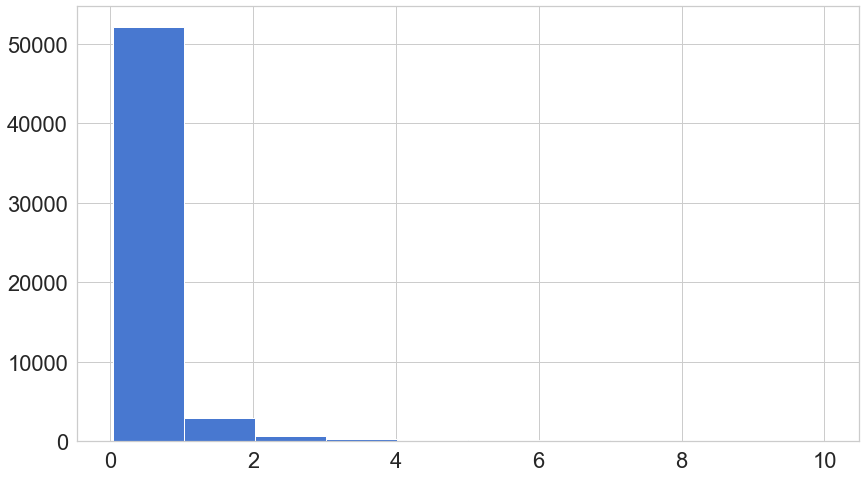

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

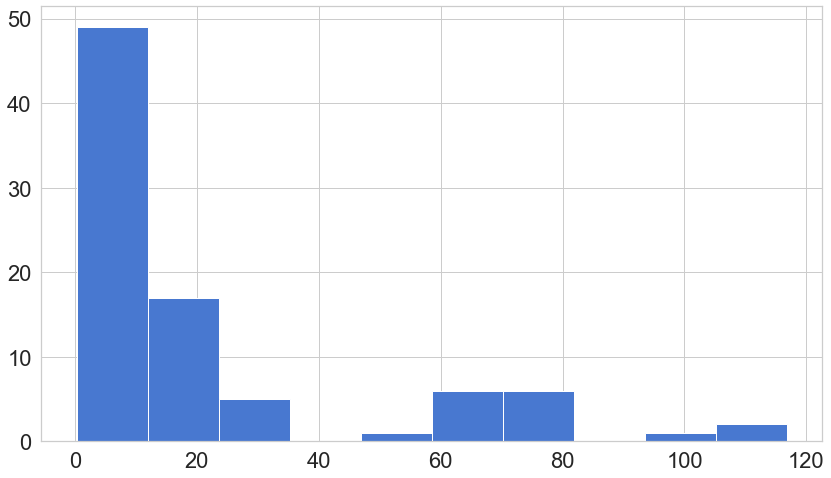

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [55]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [56]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

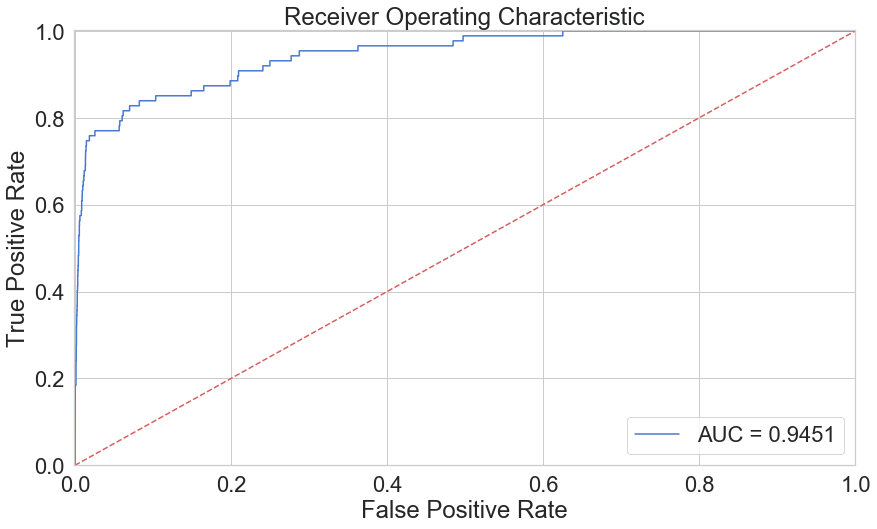

In [57]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [58]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

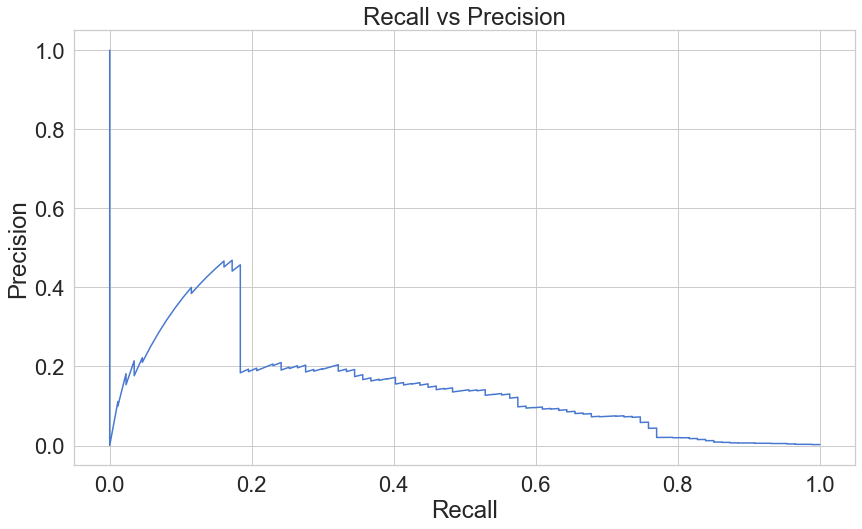

In [59]:
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


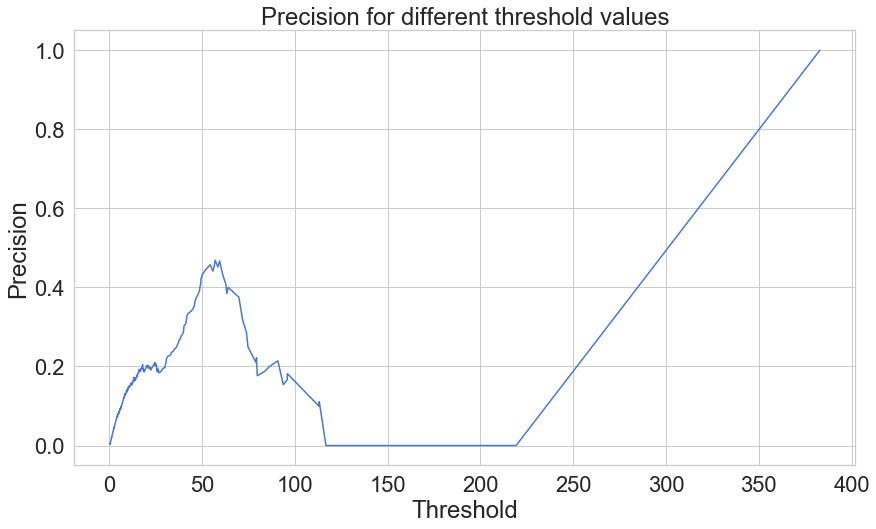

In [60]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

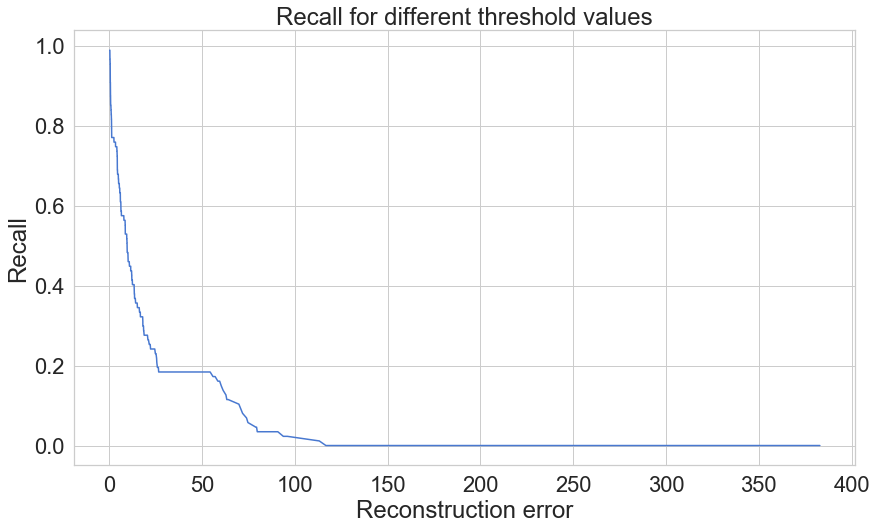

In [61]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [66]:
threshold = 2.5

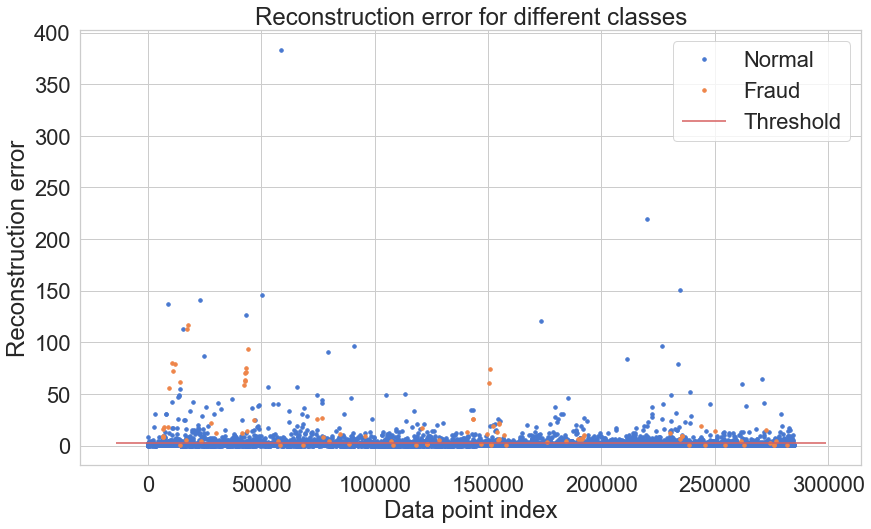

In [67]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

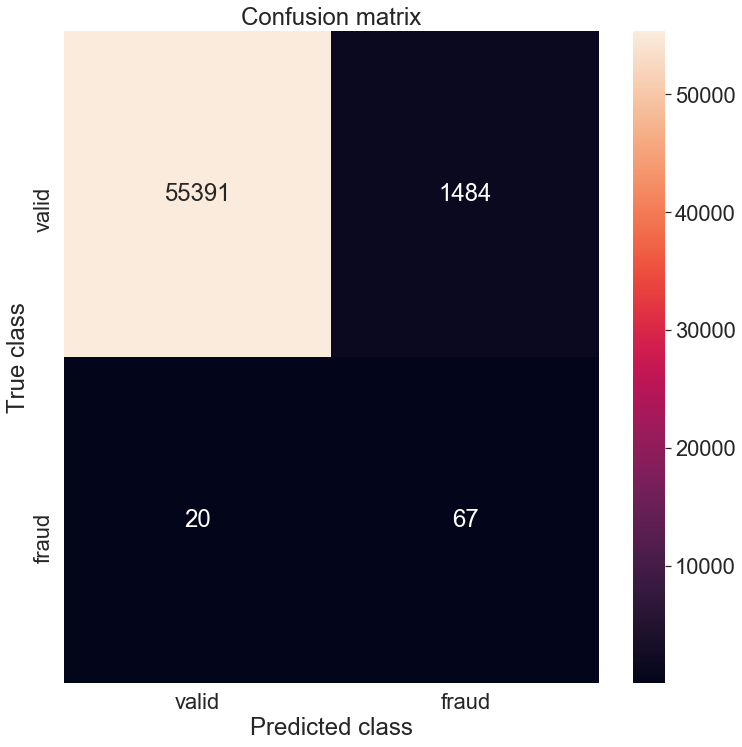

In [68]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()